# Tutorial: Spectra Analysis with Alpaga

In [1]:
#jupyter nbconvert --to python --TemplateExporter.exclude_input_prompt=True tutorial_spectra_analysis.ipynb

%reset -f
import importlib
import numpy as np
import os 
import pickle
import sys

import matplotlib
import matplotlib.pyplot as plt

import Alpaga # the full package
from Alpaga import file_management
from Alpaga import analyze_run
from Alpaga.Data_tutorial import get_tutorial_path 


## Introduction

In this tutorial, we will see how to analyze your raw spectra to extract the second harmonic intensity (or any Gaussian-shaped peak).

We will assume that one experiment is composed of a series of spectra where one physical parameter is changed (**angle**). For each angle, several spectra acquisitions can be performed, which we call **iterations**. We assume that the number of iterations is the same for all angles.

The spectra are saved in files. The way Alpaga performs the link between the angle value and iteration number is discussed in the `tutorial_file_management` notebook. Please have a look at that tutorial before doing this one.

### Tutorial Structure

This tutorial is structured as follows:
1. **Clean and average the spectra** - Remove artifacts and combine iterations
2. **Extract the Gaussian intensity** - Fit peaks and remove noise
3. **Present the automated procedure** - Complete workflow
4. **Discuss one example** - Real case study


### Prerequisites

Before starting, make sure you understand:
- File naming conventions (see `tutorial_file_management`)  
- Basic concepts: **angle** (varying parameter) and **iteration** (repeated measurements)
- Your data organization and file paths

# I. Cleaning and Averaging

During the cleaning and averaging, we will get rid of the raw file associations. Hence, this is the part where you will get rid of the naming convention issues that you may have.

> **Note**: For more information about how the cleaning is done, read the documentation wiki.

## I.A Standard Naming Convention

For each angle (or for all samples if you have only one angle), you can remove the spikes and average over all the iterations available using the `alpaga.averaging_and_cleaning` function.

### Function Parameters

**Inputs:**
- `names`: File names pattern - should be "directory + prefix"  
- `N_iter`: Number of iterations (if not specified, uses the value found in the previous part; you can select only some iterations by writing `N_iter=[1, 10]` for example)
- `L_mean_cleaning_n`, `L_mean_cleaning_evo_max`: Cleaning parameters (see documentation for details)
- `show_spectra`: 
  - `'all'` to see each treated spectrum (to adjust cleaning parameters)
  - `'average'` to see only the averaged spectrum
  - `False` to show no plots

**Outputs:**
- `L_lambda`: Contains the wavelength values
- `L_spectra`: Contains the cleaned and averaged spectrum over the `N_iter` available spectra

### Basic Usage Example

We will use data stored in the tutorial directory. These data have been recorded using our standard naming convention (defined using `Alpaga.file_management.standard_file_name`). Hence, we can directly "read" the directory where these data are stored using `Alpaga.file_management.find_angle_iter_from_dir`.

In [2]:
directory = get_tutorial_path("SHS/Eau_polar_V")
prefix_file, L_files_angles, N_iter, extension = Alpaga.file_management.find_angle_iter_from_dir(directory)
print("prefix_file=", prefix_file)
print("L_files_angles=", L_files_angles)
print("N_iter=", N_iter)
print("extension=", extension)

I will look at file with the extension .dat in the directory /home/glebreton/.local/lib/python3.7/site-packages/Alpaga/Data_tutorial/SHS/Eau_polar_Vfor angle dependent values. The type of the files should be: prefix_angle_iter.extension
prefix_file= Spectre
L_files_angles= ['4.0', '8.0', '12.0', '16.0', '20.0', '24.0', '28.0', '32.0', '36.0', '40.0', '44.0', '48.0', '52.0', '56.0', '60.0', '64.0', '68.0', '72.0', '76.0', '80.0', '84.0', '88.0', '92.0', '96.0', '100.0', '104.0', '108.0', '112.0', '116.0', '120.0', '124.0', '128.0', '132.0', '136.0', '140.0', '144.0', '148.0', '152.0', '156.0', '160.0', '164.0', '168.0', '172.0', '176.0', '180.0', '184.0', '188.0']
N_iter= 12
extension= .dat


### File Reference Example

In [3]:
myangle= L_files_angles[5] # [5] targets the 6th element 
nbriter = str(5) # should be string and below N_iter

print("prefix_file=", prefix_file)
print("myangle=", myangle)
print("nbriter=", nbriter)
print("extension=", extension)
print("name of the file=", Alpaga.file_management.standard_file_name(prefix_file, angle=myangle, iteration=nbriter, extension=extension))


prefix_file= Spectre
myangle= 24.0
nbriter= 5
extension= .dat
name of the file= Spectre_24.0_5.dat


### Cleaning Procedure

In this context, we can call directly the `averaging_and_cleaning` function. If parameter show_spectra is set to 'all', this function will show each treated spectra and, as last graph, the averaged and cleaned spectra for this angle. This function works for a given angle, here for instance the first one:

Averaging will be done for iterations from 1 to 12
/home/glebreton/.local/lib/python3.7/site-packages/Alpaga/Data_tutorial/SHS/Eau_polar_V/Spectre_4.0_1.dat
/home/glebreton/.local/lib/python3.7/site-packages/Alpaga/Data_tutorial/SHS/Eau_polar_V/Spectre_4.0_2.dat
/home/glebreton/.local/lib/python3.7/site-packages/Alpaga/Data_tutorial/SHS/Eau_polar_V/Spectre_4.0_3.dat
/home/glebreton/.local/lib/python3.7/site-packages/Alpaga/Data_tutorial/SHS/Eau_polar_V/Spectre_4.0_4.dat
/home/glebreton/.local/lib/python3.7/site-packages/Alpaga/Data_tutorial/SHS/Eau_polar_V/Spectre_4.0_5.dat
/home/glebreton/.local/lib/python3.7/site-packages/Alpaga/Data_tutorial/SHS/Eau_polar_V/Spectre_4.0_6.dat
/home/glebreton/.local/lib/python3.7/site-packages/Alpaga/Data_tutorial/SHS/Eau_polar_V/Spectre_4.0_7.dat
/home/glebreton/.local/lib/python3.7/site-packages/Alpaga/Data_tutorial/SHS/Eau_polar_V/Spectre_4.0_8.dat
/home/glebreton/.local/lib/python3.7/site-packages/Alpaga/Data_tutorial/SHS/Eau_polar_V/Spectre_4.0_9

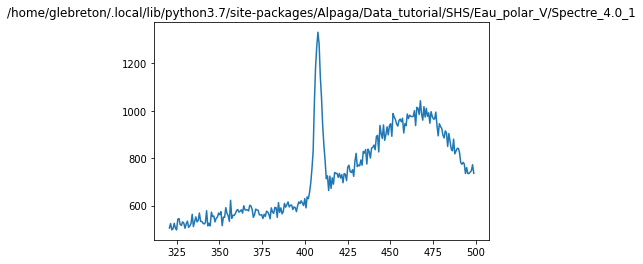

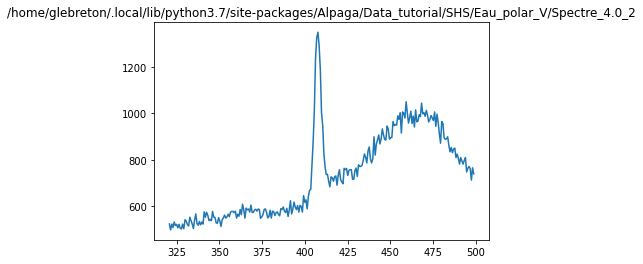

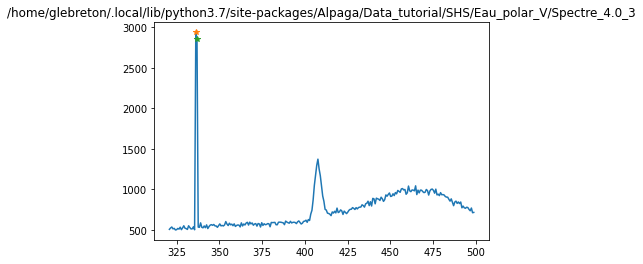

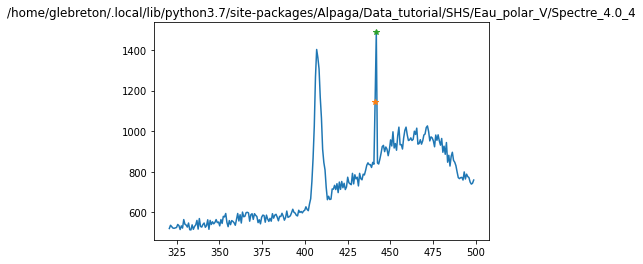

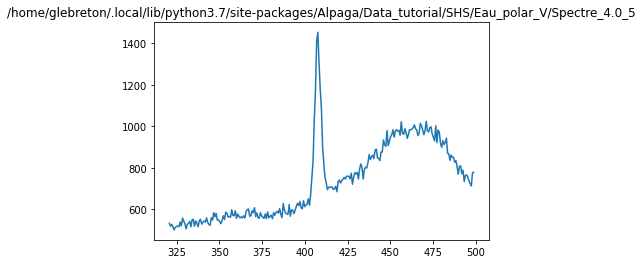

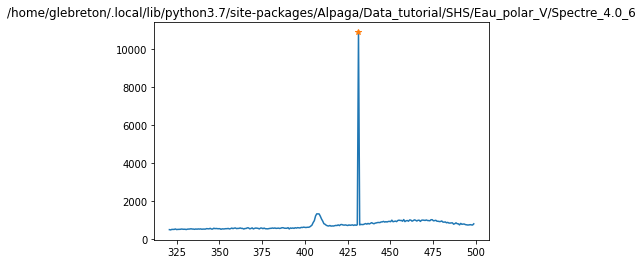

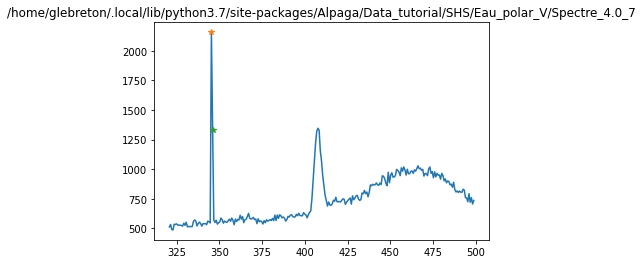

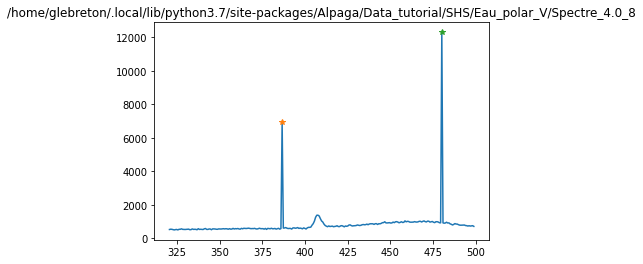

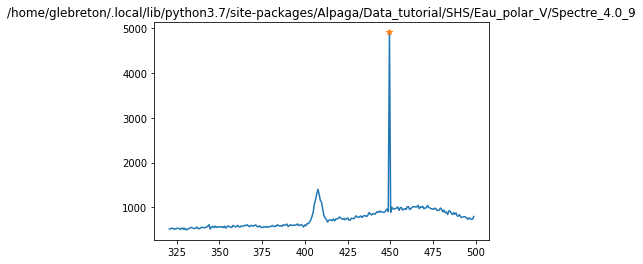

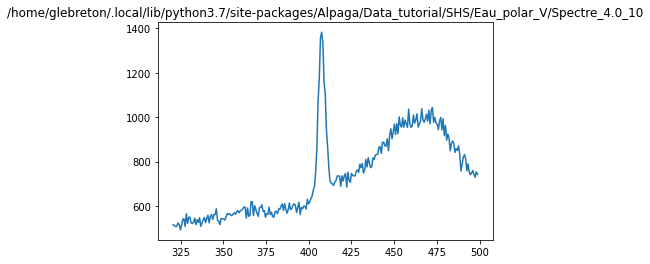

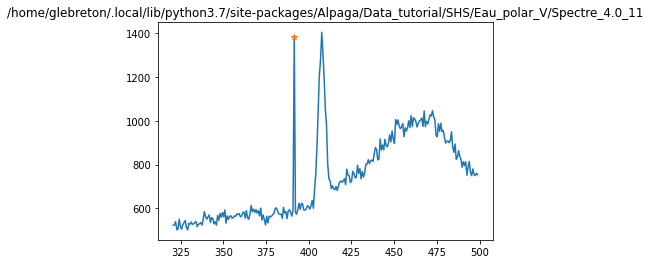

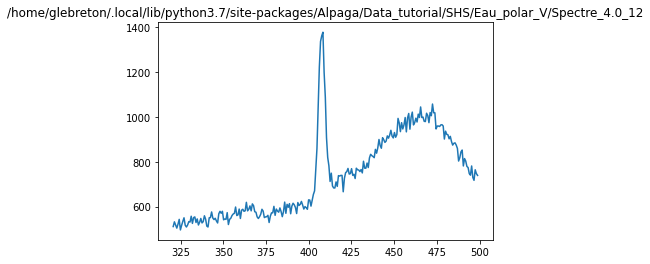

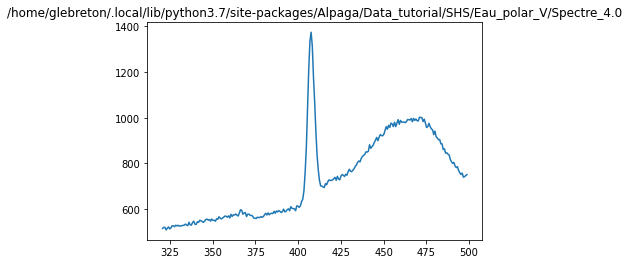

In [4]:
# The cleaning procedure should be called for a single angle at a time
directory = get_tutorial_path("SHS/Eau_polar_V")
names = os.path.join(directory, prefix_file) + '_' + L_files_angles[0]

# You are giving a function as argument here: 
fct_name = Alpaga.file_management.standard_file_name  # Links names + iteration + extension to file

# Cleaning parameters (see documentation for details)
L_mean_cleaning_n = [1, 1, 1, 3]
L_mean_cleaning_evo_max = [2, 1.5, 1.4, 1.3]

# Perform cleaning and averaging
L_lambda, L_spectra, _ = Alpaga.analyze_run.averaging_and_cleaning(
    names, N_iter, 
    extension='.dat', 
    fct_name=fct_name, 
    type_cleaning='mean', 
    L_mean_cleaning_n=L_mean_cleaning_n, 
    L_mean_cleaning_evo_max=L_mean_cleaning_evo_max, 
    show_spectra='all', 
    figure_counter=1
)


**Important Notes:**
- `names` should be: `directory + prefix`
- `N_iter` here is the number of iterations found in the previous part (here 12)
- `L_lambda` contains the wavelength values
- `L_spectra` contains the cleaned and averaged spectrum over the `N_iter` available spectra


### Advanced Usage: Selective Averaging

If you want to average over only some iterations, set `N_iter` to a list of the iterations you want to average. For instance, to average over iterations 1 and 10:

I will look at file with the extension .dat in the directory /home/glebreton/.local/lib/python3.7/site-packages/Alpaga/Data_tutorial/SHS/Eau_polar_Vfor angle dependent values. The type of the files should be: prefix_angle_iter.extension
Averaging will be done for iterations: [1, 10]
/home/glebreton/.local/lib/python3.7/site-packages/Alpaga/Data_tutorial/SHS/Eau_polar_V/Spectre_4.0_1.dat
/home/glebreton/.local/lib/python3.7/site-packages/Alpaga/Data_tutorial/SHS/Eau_polar_V/Spectre_4.0_10.dat


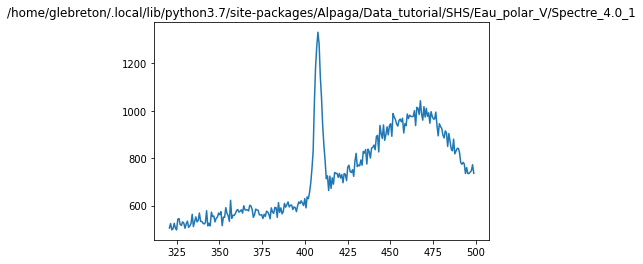

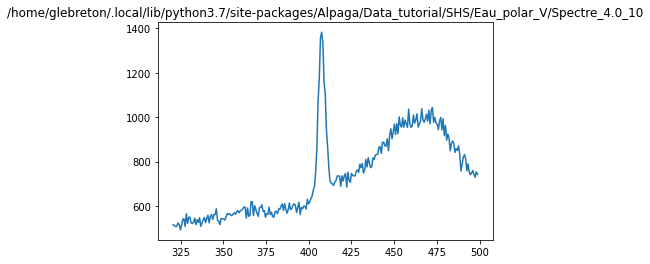

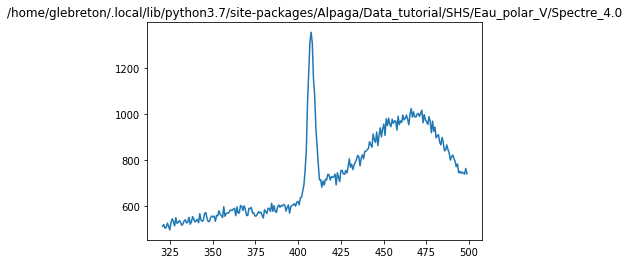

In [5]:
directory = get_tutorial_path("SHS/Eau_polar_V")
prefix_file, L_files_angles, N_iter, extension = Alpaga.file_management.find_angle_iter_from_dir(directory)
names = os.path.join(directory, prefix_file) + '_' + L_files_angles[0] 

N_iter = [1, 10]
L_mean_cleaning_n = [1, 1, 1, 3] # see wiki 
L_mean_cleaning_evo_max = [2, 1.5, 1.4, 1.3] # see wiki 

L_lambda, L_spectra, _ = Alpaga.analyze_run.averaging_and_cleaning(names, N_iter, extension='.dat', type_cleaning='mean', L_mean_cleaning_n=L_mean_cleaning_n, L_mean_cleaning_evo_max=L_mean_cleaning_evo_max, show_spectra='all', figure_counter=1)

### Single Spectrum Processing

If you want to only clean (not average) the spectra, use a list with one single element:

I will look at file with the extension .dat in the directory /home/glebreton/.local/lib/python3.7/site-packages/Alpaga/Data_tutorial/SHS/Eau_polar_Vfor angle dependent values. The type of the files should be: prefix_angle_iter.extension
Averaging will be done for iterations: [2]
/home/glebreton/.local/lib/python3.7/site-packages/Alpaga/Data_tutorial/SHS/Eau_polar_V/Spectre_4.0_2.dat


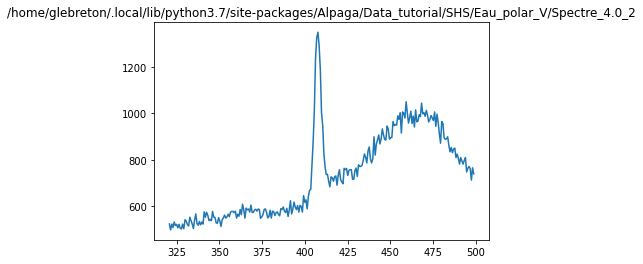

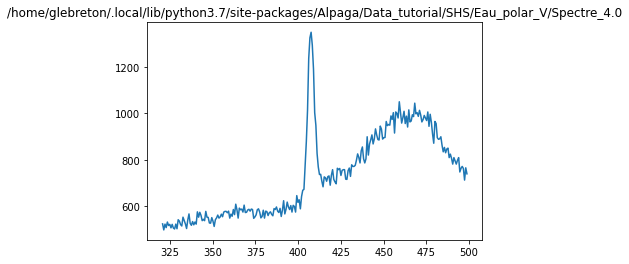

In [6]:
directory = get_tutorial_path("SHS/Eau_polar_V")
prefix_file, L_files_angles, N_iter, extension = Alpaga.file_management.find_angle_iter_from_dir(directory)

names = os.path.join(directory, prefix_file) + '_' + L_files_angles[0]

N_iter = [2]

L_mean_cleaning_n = [1, 1, 1, 3] # see wiki 
L_mean_cleaning_evo_max = [2, 1.5, 1.4, 1.3] # see wiki 

L_lambda, L_spectra, _ = Alpaga.analyze_run.averaging_and_cleaning(names, N_iter, extension='.dat', type_cleaning='mean', L_mean_cleaning_n=L_mean_cleaning_n, L_mean_cleaning_evo_max=L_mean_cleaning_evo_max, show_spectra='all', figure_counter=1)

## I.B Custom Naming Convention

Let's say you have a different naming convention, but it is close enough to stay within the Alpaga "framework". Define your own naming convention function:

In [7]:
def my_convention_file_name(prefixe, angle=False, iteration=False, extension='.dat'):
    '''
    This is in fact the Alpaga.file_management.standard_file_name function because we are dealing with the same data. 
    For your data, change the lines with the # change here  
    '''
    if isinstance(angle, bool):
        if isinstance(iteration, bool):
            name = prefixe + extension # change here 
        else:
            name = prefixe + '_' + iteration + extension # change here 
    else:
        if isinstance(iteration, bool):
            name = prefixe + '_' + angle + extension # change here 
        else: 
            name = prefixe + '_' + angle + '_' + iteration + extension # change here 
    return(name)

And check it: 

In [8]:
prefix_file = 'Spectre' # this should be define in function of your datas
L_files_angles = ['4.0', '12.0', '24.0'] # this should be define in function of your datas
N_iter = 5 # this should be define in function of your datas
extension = '.dat' # this should be define in function of your datas


myangle = L_files_angles[1] # [1] targets the 2nd element 

print("prefix_file=", prefix_file)
print("myangle=", myangle)
print("nbriter=", nbriter)
print("extension=", extension)
print("name of the file=", my_convention_file_name(prefix_file, angle=myangle, iteration=str(N_iter), extension=extension))


prefix_file= Spectre
myangle= 12.0
nbriter= 5
extension= .dat
name of the file= Spectre_12.0_5.dat


### Using Custom Convention

Again, in this example we are using the same naming convention, but in principle, you can use another convention with your function `my_convention_file_name`. To perform the cleaning, use:

Averaging will be done for iterations from 1 to 5
/home/glebreton/.local/lib/python3.7/site-packages/Alpaga/Data_tutorial/SHS/Eau_polar_V/Spectre_4.0_1.dat
/home/glebreton/.local/lib/python3.7/site-packages/Alpaga/Data_tutorial/SHS/Eau_polar_V/Spectre_4.0_2.dat
/home/glebreton/.local/lib/python3.7/site-packages/Alpaga/Data_tutorial/SHS/Eau_polar_V/Spectre_4.0_3.dat
/home/glebreton/.local/lib/python3.7/site-packages/Alpaga/Data_tutorial/SHS/Eau_polar_V/Spectre_4.0_4.dat
/home/glebreton/.local/lib/python3.7/site-packages/Alpaga/Data_tutorial/SHS/Eau_polar_V/Spectre_4.0_5.dat


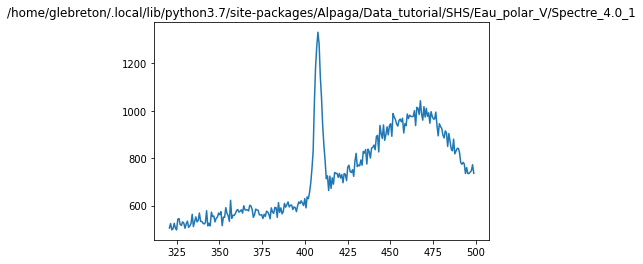

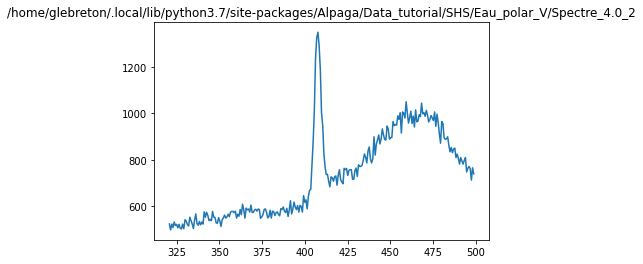

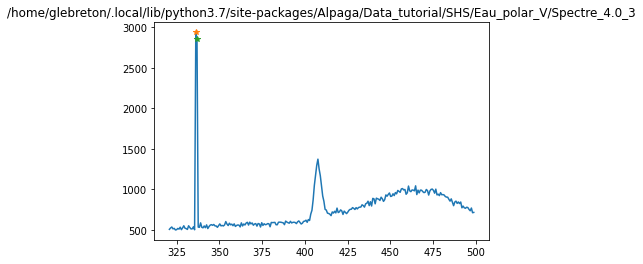

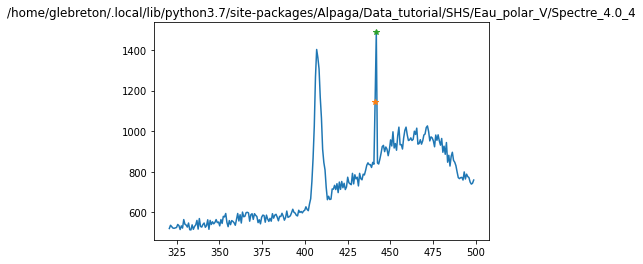

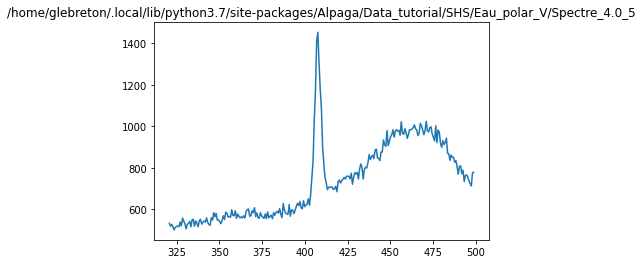

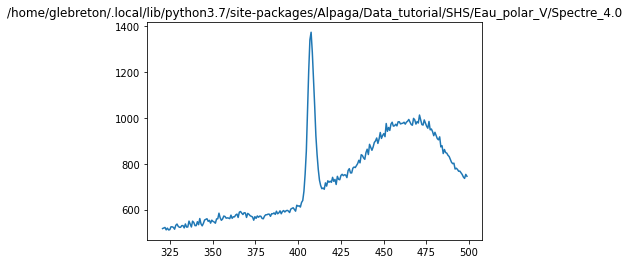

In [9]:
prefix_file = 'Spectre' # this should be define in function of your datas
L_files_angles = ['4.0', '12.0', '24.0'] # this should be define in function of your datas
N_iter = 5 # this should be define in function of your datas
extension = '.dat' # this should be define in function of your datas

# The cleaning procedure should be called for a single angle at a time:
directory = get_tutorial_path("SHS/Eau_polar_V")
names = os.path.join(directory, prefix_file) + '_' + L_files_angles[0]

# Your are giving a function as argument here: 
fct_name = my_convention_file_name # The function linking the names + iteration number + extension to the file


L_mean_cleaning_n = [1, 1, 1, 3] # see wiki 
L_mean_cleaning_evo_max = [2, 1.5, 1.4, 1.3] # see wiki 

L_lambda, L_spectra, _ = Alpaga.analyze_run.averaging_and_cleaning(names, N_iter, extension='.dat', 
                                                                   fct_name=fct_name, 
                                                                   type_cleaning='mean', L_mean_cleaning_n=L_mean_cleaning_n, 
                                                                   L_mean_cleaning_evo_max=L_mean_cleaning_evo_max, show_spectra='all', 
                                                                   figure_counter=1)


> **Note**: You will be able to call the automated procedure using your custom naming convention function.


## I.C Manual File List (Advanced)

If using a custom naming function is not possible, then you should provide to `Alpaga.analyze_run.averaging_and_cleaning` a list of the filenames to treat. For instance:

In [10]:
directory = get_tutorial_path("SHS/Eau_polar_V")
L_filename = ['Spectre_4.0_1.dat', 'Spectre_4.0_2.dat', 'Spectre_4.0_3.dat']
L_filename = [directory + '/' + L_filename[k] for k in range(len(L_filename))]
print(L_filename)


['/home/glebreton/.local/lib/python3.7/site-packages/Alpaga/Data_tutorial/SHS/Eau_polar_V/Spectre_4.0_1.dat', '/home/glebreton/.local/lib/python3.7/site-packages/Alpaga/Data_tutorial/SHS/Eau_polar_V/Spectre_4.0_2.dat', '/home/glebreton/.local/lib/python3.7/site-packages/Alpaga/Data_tutorial/SHS/Eau_polar_V/Spectre_4.0_3.dat']


Then call the function by adding the extra argument `L_filename` (you can define or not `extension` and `fct_name`, they will not be used anyway):

Averaging will be done for iterations from 1 to 3
/home/glebreton/.local/lib/python3.7/site-packages/Alpaga/Data_tutorial/SHS/Eau_polar_V/Spectre_4.0_1.dat
/home/glebreton/.local/lib/python3.7/site-packages/Alpaga/Data_tutorial/SHS/Eau_polar_V/Spectre_4.0_1.dat
/home/glebreton/.local/lib/python3.7/site-packages/Alpaga/Data_tutorial/SHS/Eau_polar_V/Spectre_4.0_1.dat


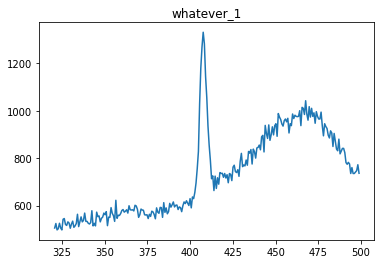

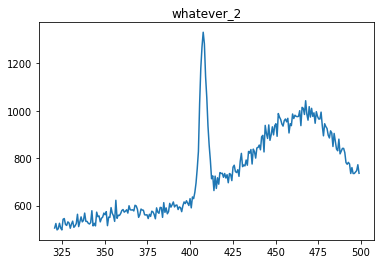

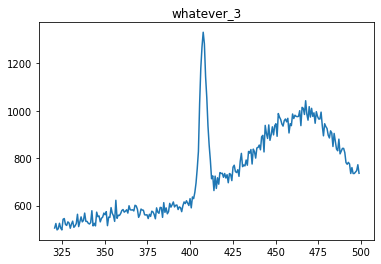

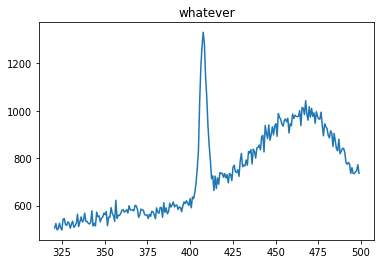

In [11]:
directory = get_tutorial_path("SHS/Eau_polar_V")
names = 'whatever' # this argument has no use here
L_filename = ['Spectre_4.0_1.dat', 'Spectre_4.0_2.dat', 'Spectre_4.0_3.dat']
L_filename = [directory + '/' + L_filename[k] for k in range(len(L_filename))]
N_iter = 3

L_mean_cleaning_n = [1, 1, 1, 3] # see wiki 
L_mean_cleaning_evo_max = [2, 1.5, 1.4, 1.3] # see wiki 

L_lambda, L_spectra, _ = Alpaga.analyze_run.averaging_and_cleaning(names, N_iter, 
                                                                   L_filename=L_filename,
                                                                   extension='.dat', 
                                                                   type_cleaning='mean', L_mean_cleaning_n=L_mean_cleaning_n, 
                                                                   L_mean_cleaning_evo_max=L_mean_cleaning_evo_max, show_spectra='all', 
                                                                   figure_counter=1)

## Summary of Part I


| **Method** | **Use Case** | **Key Parameters** |
|------------|--------------|-------------------|
| **Standard** | Files follow `prefix_angle_iteration.extension` | Use `standard_file_name` |
| **Custom** | Similar pattern, different separators | Define `my_convention_file_name` |
| **Manual** | Completely different file organization | Provide `L_filename` list |

**Key Outputs:**
- `L_lambda`: Wavelength array
- `L_spectra`: Cleaned and averaged spectrum
- Ready for noise removal and Gaussian fitting (Part II)

**Next Steps:**
- Part II: Noise removal and Gaussian fitting
- Part III: Automated workflow for multiple angles

# II. Noise and Fit

Now that we have gotten rid of the "unphysical" perturbations, let us analyze the averaged spectra for a given angle.  

In the following, we will stick to the original naming convention, but you may also use other options as long as the spectra cleaning is done properly (see the previous part).  

The spectra generally contain the Gaussian peak that we want to study, but also some noise due to fluorescence or unwanted light.  
We will first adjust the parameters that allow us to distinguish noise from signal.  
Then, we will fit the signal with a Gaussian.  



I will look at file with the extension .dat in the directory /home/glebreton/.local/lib/python3.7/site-packages/Alpaga/Data_tutorial/SHS/Eau_polar_Vfor angle dependent values. The type of the files should be: prefix_angle_iter.extension
/home/glebreton/.local/lib/python3.7/site-packages/Alpaga/Data_tutorial/SHS/Eau_polar_V/Spectre_4.0_1.dat
/home/glebreton/.local/lib/python3.7/site-packages/Alpaga/Data_tutorial/SHS/Eau_polar_V/Spectre_4.0_2.dat
/home/glebreton/.local/lib/python3.7/site-packages/Alpaga/Data_tutorial/SHS/Eau_polar_V/Spectre_4.0_3.dat
/home/glebreton/.local/lib/python3.7/site-packages/Alpaga/Data_tutorial/SHS/Eau_polar_V/Spectre_4.0_4.dat
/home/glebreton/.local/lib/python3.7/site-packages/Alpaga/Data_tutorial/SHS/Eau_polar_V/Spectre_4.0_5.dat
/home/glebreton/.local/lib/python3.7/site-packages/Alpaga/Data_tutorial/SHS/Eau_polar_V/Spectre_4.0_6.dat
/home/glebreton/.local/lib/python3.7/site-packages/Alpaga/Data_tutorial/SHS/Eau_polar_V/Spectre_4.0_7.dat
/home/glebreton/.loca

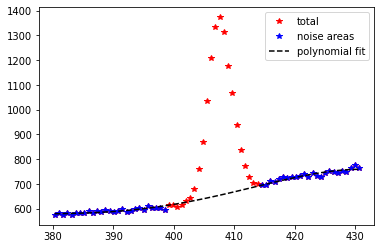

In [12]:
# To check how the noise is removed:
directory = get_tutorial_path("SHS/Eau_polar_V")
prefix_file, L_files_angles, N_iter, extension = Alpaga.file_management.find_angle_iter_from_dir(directory)

names = os.path.join(directory, prefix_file) + '_' + L_files_angles[0]

L_mean_cleaning_n = [1, 1, 1, 3]
L_mean_cleaning_evo_max = [2, 1.5, 1.3, 1.3]

L_lambda, L_spectra, _ = Alpaga.analyze_run.averaging_and_cleaning(names, N_iter, extension='.dat', type_cleaning='mean', L_mean_cleaning_n=L_mean_cleaning_n, L_mean_cleaning_evo_max=L_mean_cleaning_evo_max, show_spectra=False, figure_counter=1)

l_cut = [380, 399, 414, 431]
order_fit_noise = 4

L_x_cleaned, L_y_cleaned, L_y_noise_fit, x_cut, figure_counter = Alpaga.analyze_run.remove_noise(L_lambda, L_spectra, l_cut=l_cut, order_fit_noise=order_fit_noise, return_fit_noise=True, return_boundary=True, show_spectra='all', figure_counter=1)



To get the position of the area, use: x_cut  [ 85 112 134 158]
Check the target and the valued used. Used: 380.319 target (l_cut): 380
Check the target and the valued used. Used: 399.21 target (l_cut): 399
Check the target and the valued used. Used: 414.584 target (l_cut): 414
Check the target and the valued used. Used: 431.334 target (l_cut): 431


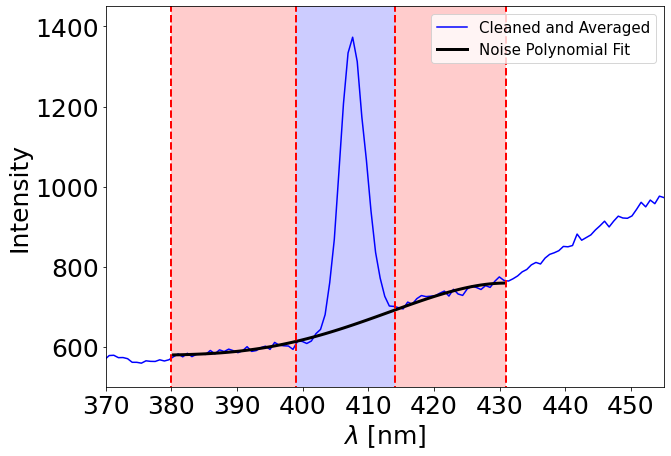

In [13]:
# The output: 
fig, ax = plt.subplots(figsize=(10, 7))

plt.plot(L_lambda, L_spectra, '-b', label='Cleaned and Averaged', lw=1.5)
plt.plot(L_x_cleaned, L_y_noise_fit, '-k', label='Noise Polynomial Fit', lw=3)
plt.plot([l_cut[0], l_cut[0]], [0, 1e4], '--r', lw=2)
plt.plot([l_cut[1], l_cut[1]], [0, 1e4], '--r', lw=2)
plt.plot([l_cut[2], l_cut[2]], [0, 1e4], '--r', lw=2)
plt.plot([l_cut[3], l_cut[3]], [0, 1e4], '--r', lw=2)
ax.axvspan(l_cut[0], l_cut[1], facecolor='red', alpha=0.2)   # between 1st and 2nd
ax.axvspan(l_cut[1], l_cut[2], facecolor='blue', alpha=0.2)  # between 2nd and 3rd
ax.axvspan(l_cut[2], l_cut[3], facecolor='red', alpha=0.2)   # between 3rd and 4th

#plt.xlim([L_x_cleaned[0], L_x_cleaned[-1]])
#plt.ylim([np.min(L_y_noise_fit)*0.9, np.max(L_y_noise_fit)*1.1])
plt.xlim([370, 455])
plt.ylim([500, 1450])
plt.xticks(fontsize=25)
plt.xlabel(r'$\lambda$ [nm]', fontsize=25)
plt.ylabel(r'Intensity', fontsize=25)
plt.yticks(fontsize=25)
plt.legend(fontsize=15)

print('To get the position of the area, use: x_cut ', x_cut)
print('Check the target and the valued used. Used:', L_lambda[x_cut[0]],  'target (l_cut):', l_cut[0])
print('Check the target and the valued used. Used:', L_lambda[x_cut[1]],  'target (l_cut):', l_cut[1])
print('Check the target and the valued used. Used:', L_lambda[x_cut[2]],  'target (l_cut):', l_cut[2])
print('Check the target and the valued used. Used:', L_lambda[x_cut[3]],  'target (l_cut):', l_cut[3])


To fit the Gaussian intensity from the averaged and cleaned spectra, use the function `fit_gaussian_from_noise`.  

The inputs are:  

- The 4 values of `l_cut` define 3 areas in the spectrum with respect to the wavelength.  
  From the first to the second: the left area.  
  From the second to the third: the middle area.  
  From the third to the fourth: the right area.  
  The first and last areas should correspond to "noise", while the middle area should contain both the Gaussian and the noise.  
  A polynomial fit is performed within the left and right areas, *without* the middle part of the spectra, where the Gaussian is located.  
  Therefore, try to set the first and last values where the noise is smooth enough to be fitted by a polynomial.  
  The second and third values should not be too close to the Gaussian, and not too far away.  
  Too close would reduce the Gaussian’s intensity, while too far could lead to a poor noise fit within the Gaussian region.  

- The order of the polynomial used for the fit.  

- `bounds_fit_gausse` sets the bounds for the fit parameters.  
  The first list corresponds to the minimum values, the second to the maximum values.  
  The parameters are: intensity, lambda_0, and width.  
  Please note that you should not increase the width too much, as this would lead to poor fits for low-intensity values.  


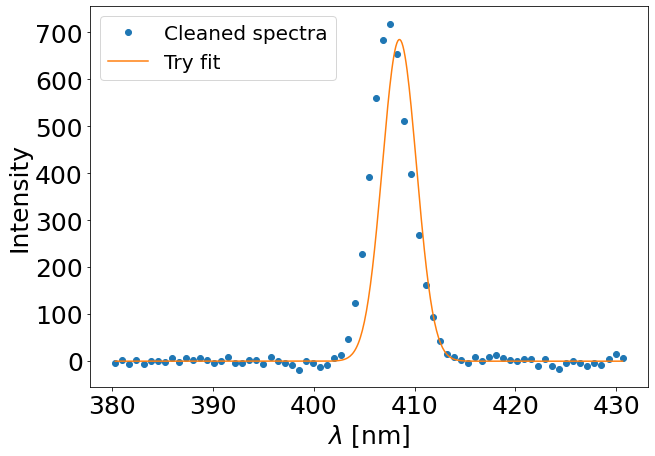

In [14]:
# humain fit: try out!
intensity = 685
lambda_0 = 408.5
omega = 2.4

L_x_for_fit = np.linspace(L_x_cleaned[0], L_x_cleaned[-1], 500)

figure_counter += 1
plt.figure(figure_counter, figsize=(10, 7))
plt.plot(L_x_cleaned, L_y_cleaned, 'o', label='Cleaned spectra', lw=2)
plt.plot(L_x_for_fit, Alpaga.analyze_run.fit_gausse(L_x_for_fit, intensity, lambda_0, omega), label='Your fit', lw=1.5)

plt.xlabel(r'$\lambda$ [nm]', fontsize=25)
plt.xticks(fontsize=25)
plt.ylabel(r'Intensity', fontsize=25)
plt.yticks(fontsize=25)
plt.legend(fontsize=20)

I will look at file with the extension .dat in the directory /home/glebreton/.local/lib/python3.7/site-packages/Alpaga/Data_tutorial/SHS/Eau_polar_Vfor angle dependent values. The type of the files should be: prefix_angle_iter.extension
/home/glebreton/.local/lib/python3.7/site-packages/Alpaga/Data_tutorial/SHS/Eau_polar_V/Spectre_4.0_1.dat
/home/glebreton/.local/lib/python3.7/site-packages/Alpaga/Data_tutorial/SHS/Eau_polar_V/Spectre_4.0_2.dat
/home/glebreton/.local/lib/python3.7/site-packages/Alpaga/Data_tutorial/SHS/Eau_polar_V/Spectre_4.0_3.dat
/home/glebreton/.local/lib/python3.7/site-packages/Alpaga/Data_tutorial/SHS/Eau_polar_V/Spectre_4.0_4.dat
/home/glebreton/.local/lib/python3.7/site-packages/Alpaga/Data_tutorial/SHS/Eau_polar_V/Spectre_4.0_5.dat
/home/glebreton/.local/lib/python3.7/site-packages/Alpaga/Data_tutorial/SHS/Eau_polar_V/Spectre_4.0_6.dat
/home/glebreton/.local/lib/python3.7/site-packages/Alpaga/Data_tutorial/SHS/Eau_polar_V/Spectre_4.0_7.dat
/home/glebreton/.loca

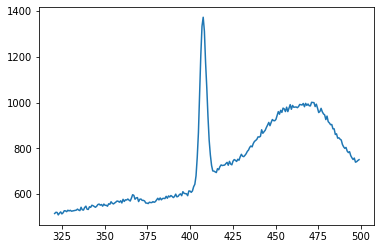

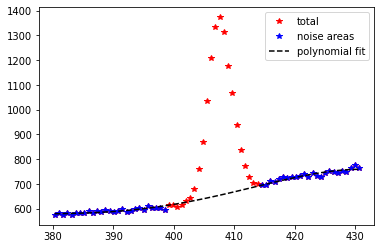

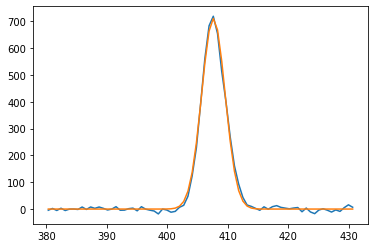

In [15]:
# Automatic procedure
directory = get_tutorial_path("SHS/Eau_polar_V")
prefix_file, L_files_angles, N_iter, extension = Alpaga.file_management.find_angle_iter_from_dir(directory)

names = os.path.join(directory, prefix_file) + '_' + L_files_angles[0]

L_mean_cleaning_n = [1, 1, 1, 3]
L_mean_cleaning_evo_max = [2, 1.5, 1.3, 1.3]

L_lambda, L_spectra, _ = Alpaga.analyze_run.averaging_and_cleaning(names, N_iter, extension='.dat', type_cleaning='mean', L_mean_cleaning_n=L_mean_cleaning_n, L_mean_cleaning_evo_max=L_mean_cleaning_evo_max, show_spectra=False, figure_counter=1)

l_cut = [380, 399, 414, 431]
order_fit_noise = 4


L_para_gauss, L_err, figure_counter = Alpaga.analyze_run.fit_gaussian_from_noise(L_lambda, L_spectra, l_cut=l_cut, order_fit_noise=order_fit_noise, bounds_fit_gausse=([0, 395, 1], [np.inf, 410, 25]), show_spectra='all')

intensity, lambda_0, omega = L_para_gauss
err_intensity, err_lambda_0, err_omega = L_err
print('Intensity:',intensity,' Lambda:',lambda_0, ' Omega: ', omega)
print('Intensity err',err_intensity, 'Lambda err:', err_lambda_0, 'Omega err:', err_omega )


/home/glebreton/.local/lib/python3.7/site-packages/Alpaga/Data_tutorial/SHS/Eau_polar_V/Spectre_4.0_1.dat
/home/glebreton/.local/lib/python3.7/site-packages/Alpaga/Data_tutorial/SHS/Eau_polar_V/Spectre_4.0_2.dat
/home/glebreton/.local/lib/python3.7/site-packages/Alpaga/Data_tutorial/SHS/Eau_polar_V/Spectre_4.0_3.dat
/home/glebreton/.local/lib/python3.7/site-packages/Alpaga/Data_tutorial/SHS/Eau_polar_V/Spectre_4.0_4.dat
/home/glebreton/.local/lib/python3.7/site-packages/Alpaga/Data_tutorial/SHS/Eau_polar_V/Spectre_4.0_5.dat
/home/glebreton/.local/lib/python3.7/site-packages/Alpaga/Data_tutorial/SHS/Eau_polar_V/Spectre_4.0_6.dat
/home/glebreton/.local/lib/python3.7/site-packages/Alpaga/Data_tutorial/SHS/Eau_polar_V/Spectre_4.0_7.dat
/home/glebreton/.local/lib/python3.7/site-packages/Alpaga/Data_tutorial/SHS/Eau_polar_V/Spectre_4.0_8.dat
/home/glebreton/.local/lib/python3.7/site-packages/Alpaga/Data_tutorial/SHS/Eau_polar_V/Spectre_4.0_9.dat
/home/glebreton/.local/lib/python3.7/site-pack

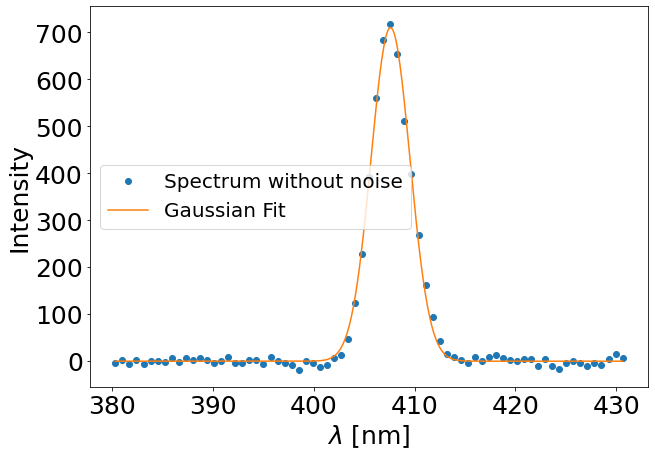

In [16]:
# To check the automatic fit:
L_lambda, L_spectra, _ = Alpaga.analyze_run.averaging_and_cleaning(names, N_iter, extension='.dat', type_cleaning='mean', L_mean_cleaning_n=L_mean_cleaning_n, L_mean_cleaning_evo_max=L_mean_cleaning_evo_max, show_spectra=False, figure_counter=1)

l_cut = [380, 399, 414, 431]
order_fit_noise = 4

L_x_cleaned, L_y_cleaned, L_y_noise_fit, x_cut, figure_counter = Alpaga.analyze_run.remove_noise(L_lambda, L_spectra, l_cut=l_cut, order_fit_noise=order_fit_noise, return_fit_noise=True, return_boundary=True, show_spectra=False, figure_counter=1)


L_x_for_fit = np.linspace(L_x_cleaned[0], L_x_cleaned[-1], 500)

figure_counter += 1
plt.figure(figure_counter, figsize=(10, 7))
plt.plot(L_x_cleaned, L_y_cleaned, 'o', label='Spectrum without noise', lw=2)
plt.plot(L_x_for_fit, Alpaga.analyze_run.fit_gausse(L_x_for_fit, intensity, lambda_0, omega), label='Gaussian Fit', lw=1.5)

plt.xlabel(r'$\lambda$ [nm]', fontsize=25)
plt.xticks(fontsize=25)
plt.ylabel(r'Intensity', fontsize=25)
plt.yticks(fontsize=25)
plt.legend(fontsize=20)



# III. Automatic procedure

## III.A Standard Naming Convention

Let us present the use with the most automatization: with the original naming convention

In [17]:
# Everything is defined thanks to the Alpaga.file_management.find_angle_iter_from_dir function.
directory = get_tutorial_path("SHS/Eau_polar_V")
prefix_file = False
L_files_angles = False 
N_iter = False
extension = '.dat'

# If working with the 3rd floor setup, change this function for the appropriate one, i.e. alpaga.third_floor_file_name_builder
fct_name = Alpaga.file_management.standard_file_name # For nanoptec and underground
# fct_name = alpaga.third_floor_file_name_builder # For 3rd floor

In [18]:
# Cleaning parameters:
type_cleaning='mean' # default
L_mean_cleaning_n = [1, 1, 1, 3]
L_mean_cleaning_evo_max = [2, 1.5, 1.4, 1.3] 

In [19]:
# Noise 
l_cut = [380, 399, 414, 431] # remember that you still need to define meaningfull l_cut parameter even if you use the automatic_l_cut method!!!
order_fit_noise = 4

automatic_l_cut = True
l_cut_n_n2 = [2, 9] # *w0


Several procedures are implemented to obtain the peak intensity :
    - one where the peak is fitted by a gaussian with all the parameters are free. To use this set method_fit_first='fit_gauss'
    - one where the peak is fitted by a gaussian with the central wavelength and gaussian width are fixed (to values obtained as the average value of previous procedure). To use this, set fixed_para_gauss_fit = True and method_fit_second = 'fit_gauss' 
    - one where the integral of the peak is used to exrtact the intensity (central wavelength and gaussian width fixed). To use this, set fixed_para_gauss_fit = True and method_fit_second = 'integral_gauss' 
    
If fixed_para_gauss_fit = True, Alpaga will run 2 times: one to compute the intensity for each polarization angle with free parameters, and another run where lambda_0 and omega_0 are fixed. 

In [20]:
# Fit the gaussian parameters:
bounds_fit_gausse=([0, 404, 1], [np.inf, 410, 3])
lambda_0_ref = 407.7 # useless if you use method_fit_first='fit_gauss'
waist_ref = 2.52

method_fit_first='fit_gauss' # 'integral_gauss' or 'fit_gauss'

fixed_para_gauss_fit = True
method_fit_second = 'both' # or integral_gauss' or 'fit_gauss' or 'both'


In [21]:
# Saving the results:
save_result=False
name_save_result = os.path.join("Yourpath", 'post_prod_results.p')

During the procedure, several graphs will be plotted for each polarization angle: 

- if automatic_l_cut = False

    + The averaged spectra cleaned from the spikes
    
    + The definition of the noise and signal area
    
    + The averaged spectra with the backround removed and the Gaussian fit
    
- automatic_l_cut = True

    + The same 3 plots 
    
    + The averaged spectra cleaned from the spikes (again)
    
    + The definition of the noise and signal area with the automatic definition
    
    + The averaged spectra cleaned from the spikes with this automatic definition of the noise
    
    
Then, if fixed_para_gauss_fit = True, a second run is performed over all the polarization angles.

In [22]:
# waiting_time = False # False or a float
waiting_time = 0 # for instance use this to make Alpaga waits 5 sec between each polarization angle analysis. Doing so, you have more time to check that the fit procedure works.

Second Run, Angle: 188.0
/home/glebreton/.local/lib/python3.7/site-packages/Alpaga/Data_tutorial/SHS/Eau_polar_V/Spectre_188.0_1.dat
/home/glebreton/.local/lib/python3.7/site-packages/Alpaga/Data_tutorial/SHS/Eau_polar_V/Spectre_188.0_2.dat
/home/glebreton/.local/lib/python3.7/site-packages/Alpaga/Data_tutorial/SHS/Eau_polar_V/Spectre_188.0_3.dat
/home/glebreton/.local/lib/python3.7/site-packages/Alpaga/Data_tutorial/SHS/Eau_polar_V/Spectre_188.0_4.dat
/home/glebreton/.local/lib/python3.7/site-packages/Alpaga/Data_tutorial/SHS/Eau_polar_V/Spectre_188.0_5.dat
/home/glebreton/.local/lib/python3.7/site-packages/Alpaga/Data_tutorial/SHS/Eau_polar_V/Spectre_188.0_6.dat
/home/glebreton/.local/lib/python3.7/site-packages/Alpaga/Data_tutorial/SHS/Eau_polar_V/Spectre_188.0_7.dat
/home/glebreton/.local/lib/python3.7/site-packages/Alpaga/Data_tutorial/SHS/Eau_polar_V/Spectre_188.0_8.dat
/home/glebreton/.local/lib/python3.7/site-packages/Alpaga/Data_tutorial/SHS/Eau_polar_V/Spectre_188.0_9.dat
/ho

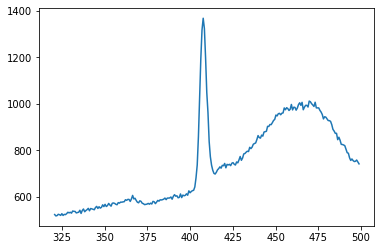

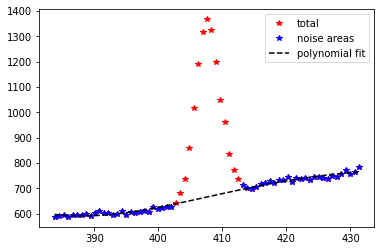

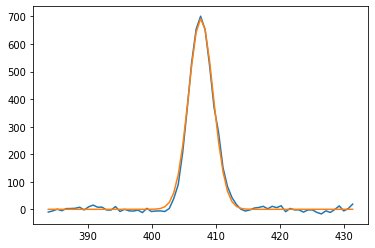

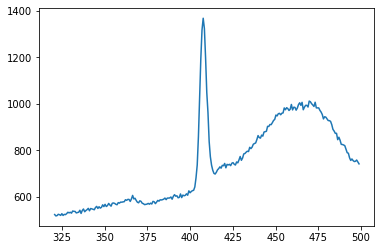

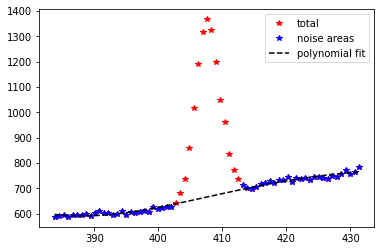

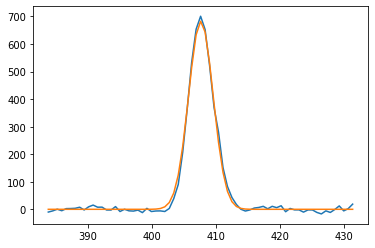

The results are not saved. Set save_result to True if you want to save them.


In [23]:
# The line to make the run: do not change anything here: all the parameter are defined above!
L_post_prod_gauss_fit_integral = Alpaga.analyze_run.polarisation_intensity(directory=directory, 
                                                                           prefix_file=prefix_file, 
                                                                           L_files_angles=L_files_angles, 
                                                                           N_iter=N_iter, 
                                                                           extension=extension, 
                                                                           fct_name=fct_name, 
                                                                           type_cleaning=type_cleaning, 
                                                                           L_mean_cleaning_n=L_mean_cleaning_n, 
                                                                           L_mean_cleaning_evo_max=L_mean_cleaning_evo_max, 
                                                                           automatic_l_cut=automatic_l_cut, 
                                                                           l_cut=l_cut, 
                                                                           l_cut_n_n2=l_cut_n_n2, 
                                                                           order_fit_noise=order_fit_noise, 
                                                                           method_fit_first=method_fit_first, 
                                                                           bounds_fit_gausse=bounds_fit_gausse, 
                                                                           lambda_0_ref=lambda_0_ref, 
                                                                           waist_ref=waist_ref, 
                                                                           fixed_para_gauss_fit=fixed_para_gauss_fit, 
                                                                           method_fit_second=method_fit_second, 
                                                                           save_result=save_result, 
                                                                           name_save_result=name_save_result, 
                                                                           waiting_time=waiting_time)


## III.B Custom Naming Convention

Just modify the fct_name. However, you will have to provide the prefix_file, L_files_angles, N_iter and extension.

In [24]:
def my_convention_file_name(prefixe, angle=False, iteration=False, extension='.dat'):
    '''
    This is in fact the Alpaga.file_management.standard_file_name function because we are dealing with the same data. 
    For your data, change the lines with the # change here  
    '''
    if isinstance(angle, bool):
        if isinstance(iteration, bool):
            name = prefixe + extension # change here 
        else:
            name = prefixe + '_' + iteration + extension # change here 
    else:
        if isinstance(iteration, bool):
            name = prefixe + '_' + angle + extension # change here 
        else: 
            name = prefixe + '_' + angle + '_' + iteration + extension # change here 
    return(name)
directory = get_tutorial_path("SHS/Eau_polar_V")
prefix_file = 'Spectre' # this should be define in function of your datas
prefix_file = os.path.join(directory, prefix_file)
L_files_angles = ['4.0', '12.0', '24.0'] # this should be define in function of your datas
N_iter = 5 # this should be define in function of your datas
extension = '.dat' # this should be define in function of your datas


fct_name = my_convention_file_name 

# If working with the 3rd floor setup, change this function for the appropriate one, i.e. file_management.third_floor_file_name_builder
# fct_name = alpaga.third_floor_file_name_builder # For 3rd floor

In [25]:
# Cleaning parameters:
type_cleaning='mean' # default
L_mean_cleaning_n = [1, 1, 1, 3]
L_mean_cleaning_evo_max = [2, 1.5, 1.4, 1.3] 

# Noise 
l_cut = [380, 399, 414, 431] # remember that you still need to define meaningfull l_cut parameter even if you use the automatic_l_cut method!!!
order_fit_noise = 4

automatic_l_cut = True
l_cut_n_n2 = [2, 9] # *w0


# Fit the gaussian parameters:
bounds_fit_gausse=([0, 404, 1], [np.inf, 410, 3])
lambda_0_ref = 407.7 # useless if you use method_fit_first='fit_gauss'
waist_ref = 2.52

method_fit_first='fit_gauss' # 'integral_gauss' or 'fit_gauss'

fixed_para_gauss_fit = True
method_fit_second = 'both' # or integral_gauss' or 'fit_gauss' or 'both'


# Saving the results:
save_result=False
name_save_result = os.path.join("SomePath", 'post_prod_results.p')
waiting_time = 0

Second Run, Angle: 24.0
/home/glebreton/.local/lib/python3.7/site-packages/Alpaga/Data_tutorial/SHS/Eau_polar_V/Spectre_24.0_1.dat
/home/glebreton/.local/lib/python3.7/site-packages/Alpaga/Data_tutorial/SHS/Eau_polar_V/Spectre_24.0_2.dat
/home/glebreton/.local/lib/python3.7/site-packages/Alpaga/Data_tutorial/SHS/Eau_polar_V/Spectre_24.0_3.dat
/home/glebreton/.local/lib/python3.7/site-packages/Alpaga/Data_tutorial/SHS/Eau_polar_V/Spectre_24.0_4.dat
/home/glebreton/.local/lib/python3.7/site-packages/Alpaga/Data_tutorial/SHS/Eau_polar_V/Spectre_24.0_5.dat


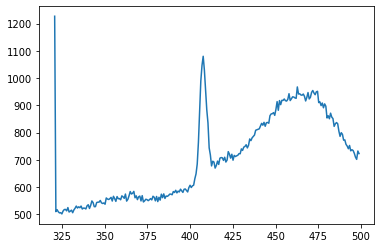

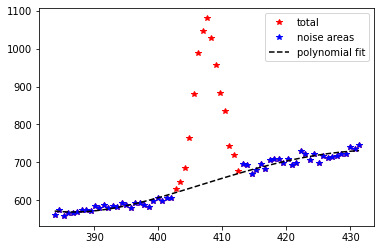

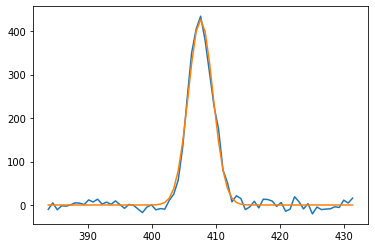

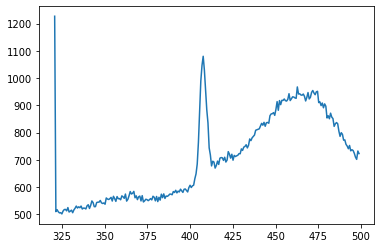

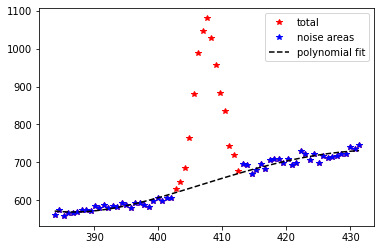

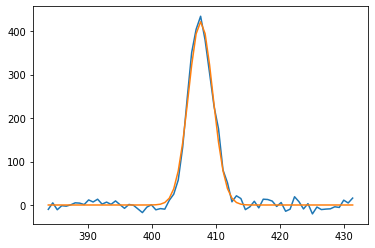

The results are not saved. Set save_result to True if you want to save them.


In [26]:
# The line to make the run: do not change anything here: all the parameter are defined above!
L_post_prod_gauss_fit_integral = Alpaga.analyze_run.polarisation_intensity(directory=False, 
                                                                           prefix_file=prefix_file, 
                                                                           L_files_angles=L_files_angles, 
                                                                           N_iter=N_iter, 
                                                                           extension=extension, 
                                                                           fct_name=fct_name, 
                                                                           type_cleaning=type_cleaning, 
                                                                           L_mean_cleaning_n=L_mean_cleaning_n, 
                                                                           L_mean_cleaning_evo_max=L_mean_cleaning_evo_max, 
                                                                           automatic_l_cut=automatic_l_cut, 
                                                                           l_cut=l_cut, 
                                                                           l_cut_n_n2=l_cut_n_n2, 
                                                                           order_fit_noise=order_fit_noise, 
                                                                           method_fit_first=method_fit_first, 
                                                                           bounds_fit_gausse=bounds_fit_gausse, 
                                                                           lambda_0_ref=lambda_0_ref, 
                                                                           waist_ref=waist_ref, 
                                                                           fixed_para_gauss_fit=fixed_para_gauss_fit, 
                                                                           method_fit_second=method_fit_second, 
                                                                           save_result=save_result, 
                                                                           name_save_result=name_save_result, 
                                                                           waiting_time=waiting_time)


## III.C Manual File List (Advanced)

If you are using a whole different way of naming / saving the spectra, you should provide the full path of each acquisition as a N_angle x N_iter list. Then, add the optional argument L_filename. 

In [27]:
directory = get_tutorial_path("SHS/Eau_polar_V")
L_files_angles = ['4', '8', '12'] # mendatory
N_iter = 3  # mendatory
# you really want to define a for loop to define this: 
L_filename_local = [
['Spectre_4.0_1.dat', 'Spectre_4.0_2.dat', 'Spectre_4.0_3.dat'],
['Spectre_8.0_1.dat', 'Spectre_8.0_2.dat', 'Spectre_8.0_3.dat'],    
['Spectre_12.0_1.dat', 'Spectre_12.0_2.dat', 'Spectre_12.0_3.dat']
]
L_filename = []
for i in range(len(L_files_angles)):
    L_filename.append([directory + '/' + L_filename_local[i][k] for k in range(N_iter)])


In [28]:
# Cleaning parameters:
type_cleaning='mean' # default
L_mean_cleaning_n = [1, 1, 1, 3]
L_mean_cleaning_evo_max = [2, 1.5, 1.4, 1.3] 

# Noise 
l_cut = [380, 399, 414, 431] # remember that you still need to define meaningfull l_cut parameter even if you use the automatic_l_cut method!!!
order_fit_noise = 4

automatic_l_cut = True
l_cut_n_n2 = [2, 9] # *w0


# Fit the gaussian parameters:
bounds_fit_gausse=([0, 404, 1], [np.inf, 410, 3])
lambda_0_ref = 407.7 # useless if you use method_fit_first='fit_gauss'
waist_ref = 2.52

method_fit_first='fit_gauss' # 'integral_gauss' or 'fit_gauss'

fixed_para_gauss_fit = True
method_fit_second = 'both' # or integral_gauss' or 'fit_gauss' or 'both'


# Saving the results:
save_result=False
name_save_result = os.path.join("SomePath", 'post_prod_results.p')
waiting_time = 0

Second Run, Angle: 12
/home/glebreton/.local/lib/python3.7/site-packages/Alpaga/Data_tutorial/SHS/Eau_polar_V/Spectre_12.0_1.dat
/home/glebreton/.local/lib/python3.7/site-packages/Alpaga/Data_tutorial/SHS/Eau_polar_V/Spectre_12.0_1.dat
/home/glebreton/.local/lib/python3.7/site-packages/Alpaga/Data_tutorial/SHS/Eau_polar_V/Spectre_12.0_1.dat


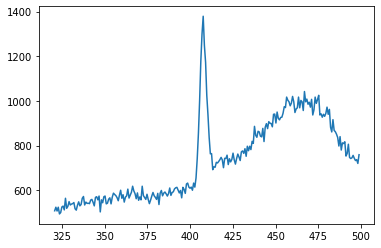

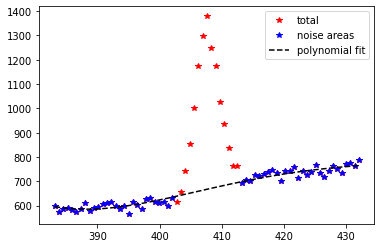

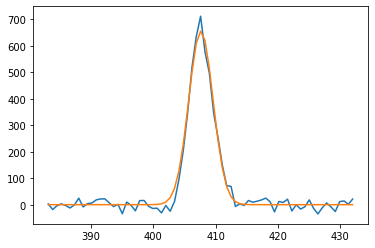

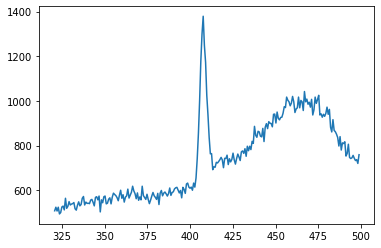

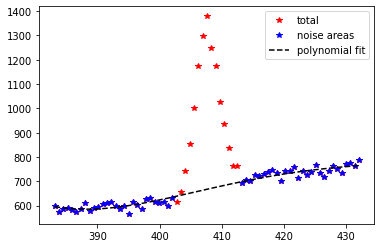

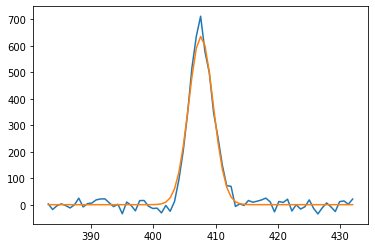

The results are not saved. Set save_result to True if you want to save them.


In [29]:
# The line to make the run: do not change anything here: all the parameter are defined above!
L_post_prod_gauss_fit_integral = Alpaga.analyze_run.polarisation_intensity(directory=False, 
                                                                           L_filename=L_filename, 
                                                                           L_files_angles=L_files_angles, 
                                                                           N_iter=N_iter, 
                                                                           type_cleaning=type_cleaning, 
                                                                           L_mean_cleaning_n=L_mean_cleaning_n, 
                                                                           L_mean_cleaning_evo_max=L_mean_cleaning_evo_max, 
                                                                           automatic_l_cut=automatic_l_cut, 
                                                                           l_cut=l_cut, 
                                                                           l_cut_n_n2=l_cut_n_n2, 
                                                                           order_fit_noise=order_fit_noise, 
                                                                           method_fit_first=method_fit_first, 
                                                                           bounds_fit_gausse=bounds_fit_gausse, 
                                                                           lambda_0_ref=lambda_0_ref, 
                                                                           waist_ref=waist_ref, 
                                                                           fixed_para_gauss_fit=fixed_para_gauss_fit, 
                                                                           method_fit_second=method_fit_second, 
                                                                           save_result=save_result, 
                                                                           name_save_result=name_save_result, 
                                                                           waiting_time=waiting_time)


# IV: Example of use - Load results and plot

In [36]:
directory = get_tutorial_path("SHS/Eau_polar_V")
name_save_result = os.path.join(directory, 'post_prod_results.p')

print("Loading results from:", name_save_result)

with open(name_save_result, "rb") as filetoload:
    L_post_prod_load = pickle.load(filetoload)

# Extract relevant data
L_files_angles = L_post_prod_load['L_files_angles']

L_files_angles_new = []
for k in range(0, len(L_files_angles), 1):
    L_files_angles_new.append(float(L_files_angles[k]))
L_polarisation_angle = np.array(L_files_angles_new)*2

L_intensity = L_post_prod_load['L_intensity']
L_intensity_error = L_post_prod_load['L_intensity_error']
L_lambda_0 = L_post_prod_load['L_lambda_0']
L_lambda_0_error = L_post_prod_load['L_lambda_0_error']
L_waist = L_post_prod_load['L_waist']
L_waist_error = L_post_prod_load['L_waist_error']
L_intensity_fit_gauss_fixed_para = L_post_prod_load['L_intensity_fit_gauss_fixed_para']
L_intensity_fit_gauss_fixed_para_error = L_post_prod_load['L_intensity_fit_gauss_fixed_para_error']
L_intensity_integral_gauss_fixed_para = L_post_prod_load['L_intensity_integral_gauss_fixed_para']
L_intensity_integral_gauss_fixed_para_error = L_post_prod_load['L_intensity_integral_gauss_fixed_para_error']



Loading results from: /home/glebreton/.local/lib/python3.7/site-packages/Alpaga/Data_tutorial/SHS/Eau_polar_V/post_prod_results.p


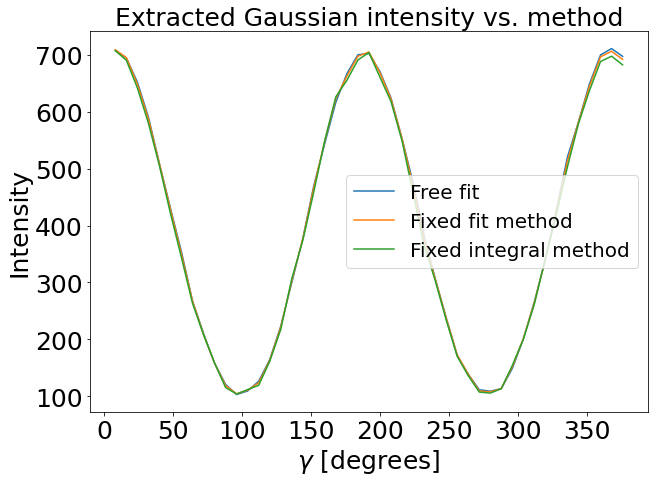

In [37]:

# ---- Plot Gaussian intensities using different methods ----
plt.figure(figsize=(10, 7))
plt.plot(L_polarisation_angle, L_intensity, label='Free fit')
plt.plot(L_polarisation_angle, L_intensity_fit_gauss_fixed_para, label='Fixed fit method')
plt.plot(L_polarisation_angle, L_intensity_integral_gauss_fixed_para, label='Fixed integral method')
plt.xlabel(r'$\gamma$ [degrees]', fontsize=25)
plt.ylabel('Intensity', fontsize=25)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.title('Extracted Gaussian intensity vs. method', fontsize=25)
plt.legend(fontsize=20)
plt.show()

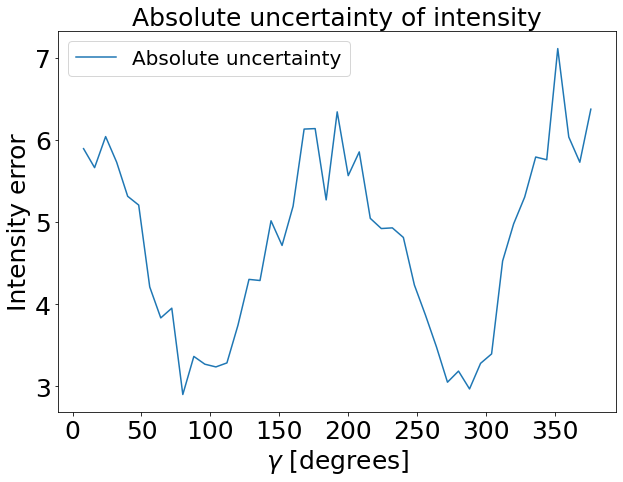

In [38]:
# ---- Absolute intensity uncertainty ----
plt.figure(figsize=(10, 7))
plt.plot(L_polarisation_angle, L_intensity_error, label='Absolute uncertainty')
plt.xlabel(r'$\gamma$ [degrees]', fontsize=25)
plt.ylabel('Intensity error', fontsize=25)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.title('Absolute uncertainty of intensity', fontsize=25)
plt.legend(fontsize=20)
plt.show()


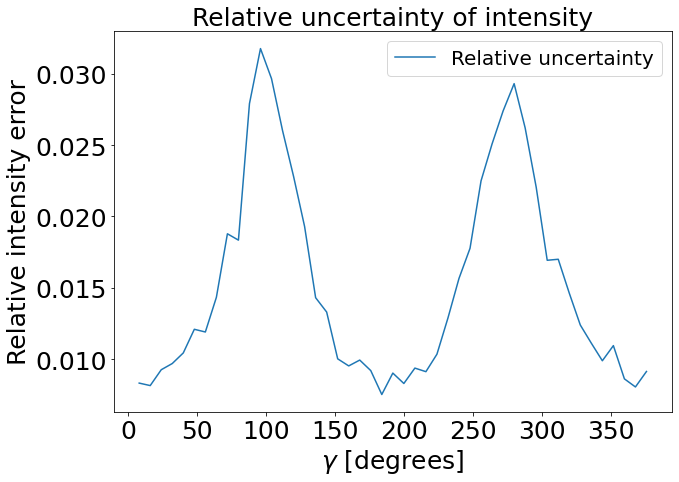

In [39]:
# ---- Relative intensity uncertainty ----
plt.figure(figsize=(10, 7))
plt.plot(L_polarisation_angle, L_intensity_error / L_intensity, label='Relative uncertainty')
plt.xlabel(r'$\gamma$ [degrees]', fontsize=25)
plt.ylabel('Relative intensity error', fontsize=25)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.title('Relative uncertainty of intensity', fontsize=25)
plt.legend(fontsize=20)
plt.show()

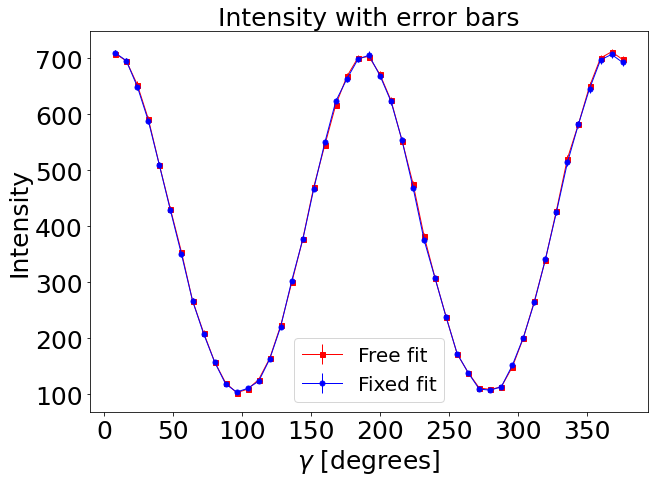

In [40]:
# ---- Errorbar plot for intensity ----
plt.figure(figsize=(10, 7))
plt.errorbar(L_polarisation_angle, L_intensity, yerr=L_intensity_error, fmt='r', marker='s', mfc='r',
             ms=5, mew=1, linewidth=1, label='Free fit')
plt.errorbar(L_polarisation_angle, L_intensity_fit_gauss_fixed_para,
             yerr=L_intensity_fit_gauss_fixed_para_error, fmt='b', marker='o', mfc='b',
             ms=5, mew=1, linewidth=1, label='Fixed fit')
plt.xlabel(r'$\gamma$ [degrees]', fontsize=25)
plt.ylabel('Intensity', fontsize=25)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.title('Intensity with error bars', fontsize=25)
plt.legend(fontsize=20)
plt.show()

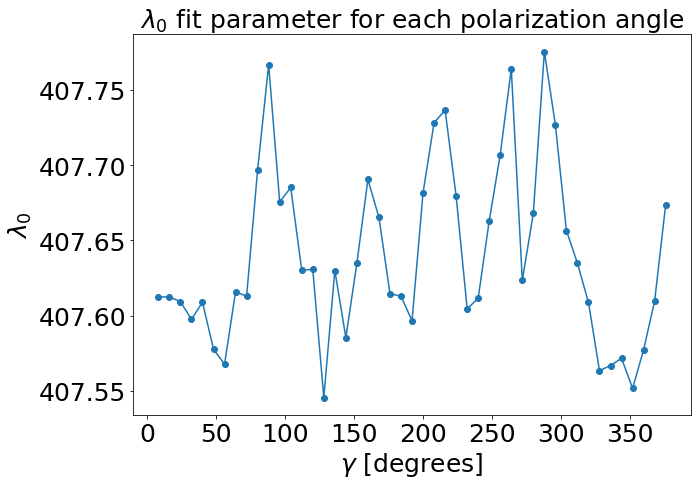

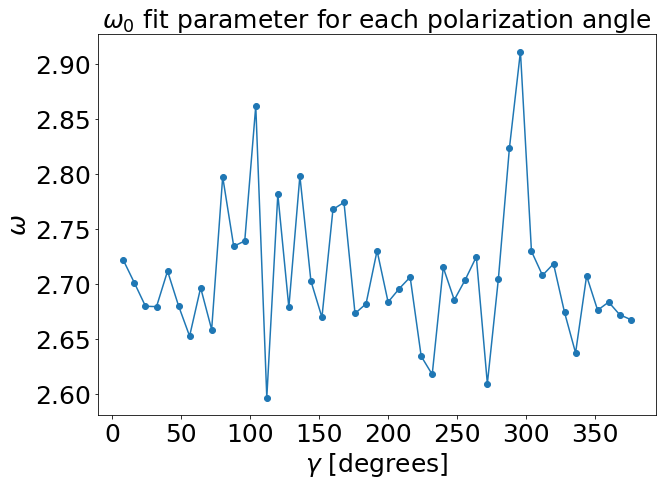

In [41]:
# ---- Fit parameter: lambda_0 ----
plt.figure(1, figsize=(10, 7))
plt.plot(L_polarisation_angle, L_lambda_0, 'o-')
plt.xlabel(r'$\gamma$ [degrees]', fontsize=25)
plt.ylabel(r'$\lambda_0$', fontsize=25)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.title(r'$\lambda_0$ fit parameter for each polarization angle', fontsize=25)
plt.show()


# ---- Fit parameter: waist ----
plt.figure(2, figsize=(10, 7))
plt.plot(L_polarisation_angle, L_waist, 'o-')
plt.xlabel(r'$\gamma$ [degrees]', fontsize=25)
plt.ylabel(r'$\omega$', fontsize=25)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.title(r'$\omega_0$ fit parameter for each polarization angle', fontsize=25)
plt.show()
